### Import the Dependencies

In [117]:
import torch
import easyocr
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Read the image, and process the image

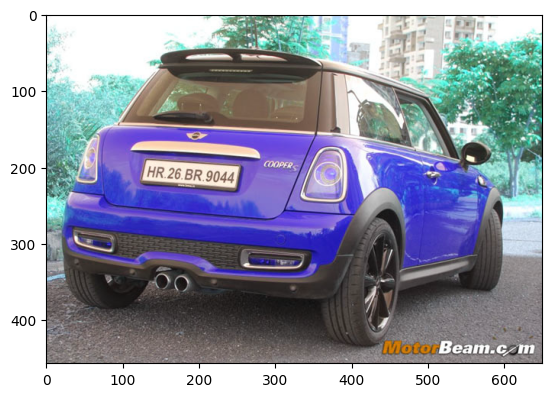

In [93]:
img = cv2.imread('image1.jpg')
base_image = img.copy()
plt.imshow(img)

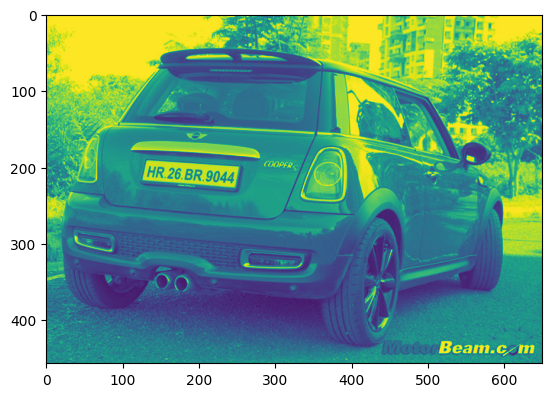

In [94]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

### Edge detection

bilateralFilter(gray, 11, 17, 12)

Bilateral filtering is used for edge-preserving smoothing. It smooths the image while keeping the edges sharp

11: The diameter of each pixel neighborhood that is used during filtering. This controls the size of the filter.

17: The standard deviation in the color space also known as sigmaColor. A larger value of sigmaColor means that farther colors within the pixel neighborhood will be mixed together, resulting in more intense smoothing of colors.

12: The standard deviation in the coordinate space also known as sigmaSpace. A larger value of sigmaSpace means that pixels farther from the central pixel will influence the filtering, making the filter smoother.

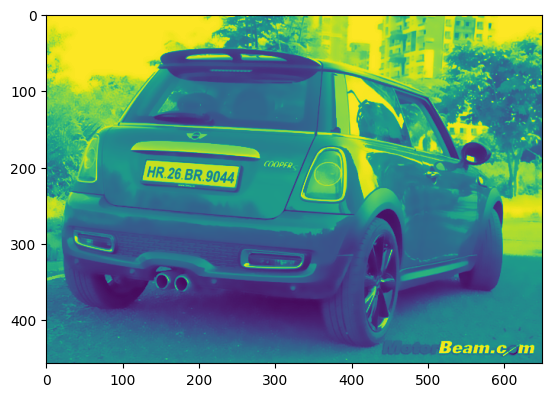

In [95]:
# apply filter / noise reduction
filter_img =  cv2.bilateralFilter(gray, 11, 17, 12)
plt.imshow(filter_img)

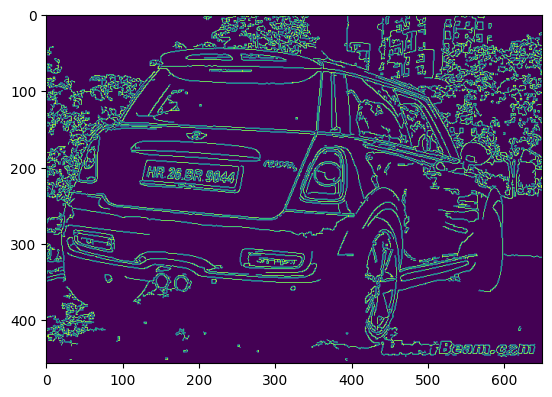

In [96]:
# Edge detections
edge = cv2.Canny(filter_img, 30, 200)
plt.imshow(edge)

### Find Contours

**cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)**

cv2.RETR_TREE: Retrieves all the contours and recontruct the full hierarchy of nested contours

cv2.CHAIN_APPROX_SIMPLE: Contour approximation method, compress the horizontal vertical and diagonal segments leaving only their end points

**imutils.grab_contours(cont_points)**

grab_contours of imutils is used to handle different version of OpenCV 'findContours' function, this function returns 2 or 3 values depending on the versions 'imutils.grab_contours' abstract the difference and make it easier to work directly with contours

**sorted(contours, key=cv2.contourArea, reverse=True)[:10]**

'cv2.contourArea' will calculate the area of the contour and sort the list accordingly in reverse order, returning the top 10 value

In [97]:
# Get the contours
cont_points = cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(cont_points)

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

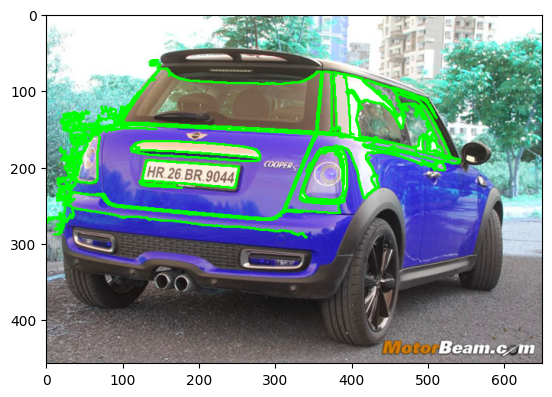

In [98]:
# Draw the contours
cv2.drawContours(base_image, contours, -1, (0,255,0), 2)
plt.imshow(base_image)

**cv2.approxPolyDP(c, 10, True)**

'approxPolyDP' function approximates a contour to a polygon with fewer vertices

10: The approximation accuracy, which is the maximum distance between the original contour and its approximation. This is often a fraction of the contour’s perimeter. In this case, 10 is a fixed value, which might need tuning depending on the scale and resolution of the image.

True: This flag indicates that the approximated polygon should be closed (i.e., the first and last points should be joined).

In [99]:
# Extract the contour with 4 points
for c in contours:
    position = cv2.approxPolyDP(c, 10, True)
    if len(position) == 4:
        plate = position
        break

In [100]:
plate

array([[[122, 219]],

       [[246, 227]],

       [[252, 200]],

       [[132, 191]]], dtype=int32)

In [101]:
# Mask the plate section out

mask_img = np.zeros(gray.shape, np.uint8)
new_img = cv2.drawContours(mask_img, [plate], 0, 255, -1)
new_img = cv2.bitwise_and(img, img, mask = mask_img)

**np.zeros(gray.shape, np.uint8)**

Create an empty black image of the same size as of gray image

**cv2.drawContours(mask_img, [plate], 0, 255, -1)**

A white portion corresponds to the region of interest that is number plate is drawn on the new image

0: The index of the contour to draw. Since there is only one contour (the license plate), the index is 0.

255: The color of the contour. 255 corresponds to white in an 8-bit grayscale image.

-1: The thickness of the contour. When set to -1, it means the contour should be filled, resulting in a filled white region on the mask where the license plate is located.


**cv2.bitwise_and(img, img, mask = mask_img)**

bitwise and operation is performed using the masked image which results only in the white portion which is our region of interest, presenting the number plate

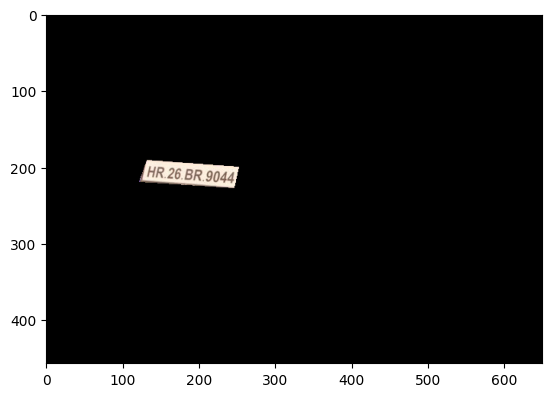

In [102]:
# display the cropped image
plt.imshow(new_img)

In [103]:
# crop the number plate from the blank image
(x,y) = np.where(mask_img == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
crop_img = gray[x1:x2+1, y1:y2+1]

**np.where(mask_img == 255)**

get the pixel coordinates of white portion in the masked image

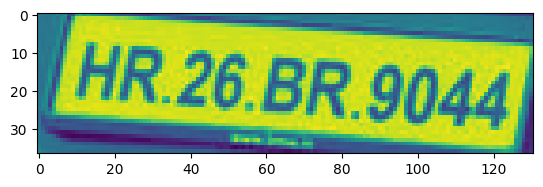

In [104]:
plt.imshow(crop_img)

### Read the number from cropped image using EasyOCR

In [105]:
reader = easyocr.Reader(['en'])
result = reader.readtext(crop_img)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\subit\anaconda3\envs\number_plate_rec\lib\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue o

[([[6, 4], [128, 4], [128, 34], [6, 34]], 'HR.26 BR.9044', 0.5728024180498563)]

#### Display the detected number on the image

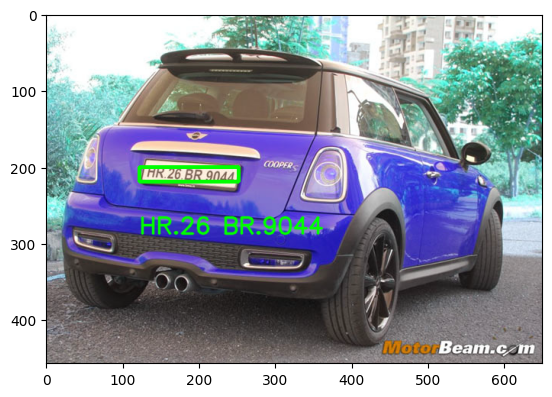

In [106]:
number = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
num_plate = cv2.putText(img, text = number, 
                        org=(position[0][0][0], position[1][0][1]+60),  fontFace=font,
                             fontScale=1, color=(0,255,0), thickness=2,
                             lineType=cv2.LINE_AA)
num_plate = cv2.rectangle(img, tuple(position[0][0]), tuple(position[2][0]),
                         (0,255,0), 3)

plt.imshow(num_plate)

### ANPR with pytesseract

In [107]:
import pytesseract

In [114]:
# CHeck with grayscale image
result = pytesseract.image_to_string(crop_img, config='--psm 8')
# The --psm 8 configuration is used to assume that the image is a single word, 
# which is helpful for number plates.
result

'| HR.26.BR 9044)\n'

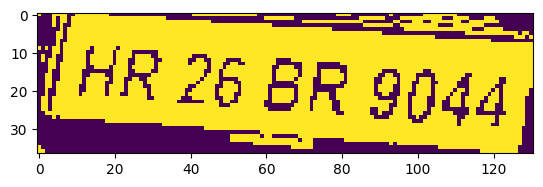

In [115]:
# Check with black and white image
# Convert image to black and white
bw_img = cv2.threshold(crop_img, 127, 255, cv2.THRESH_BINARY)[1]
plt.imshow(bw_img)

In [116]:
numb_plate = pytesseract.image_to_string(bw_img, config='--psm 8')
numb_plate

'THR 26 BR 9044,\n'